### Importing all required libraries

In [306]:
import random
import numpy as np
import io

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from PIL import Image 
import time

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import glob
import os

from IPython.display import display

# Dataset generation

### Creating a random chess board position generator

In [307]:
# Places both white and black kings at randon non-intersecting positions on the board
def place_kings(brd):
    while True:
        rank_white, file_white, rank_black, file_black = random.randint(0,7), random.randint(0,7), random.randint(0,7), random.randint(0,7)
        diff_list = [abs(rank_white - rank_black),  abs(file_white - file_black)]
        if sum(diff_list) > 2 or set(diff_list) == set([0, 2]):
            brd[rank_white][file_white], brd[rank_black][file_black] = "K", "k"
            break

# Places the rest of the pieces on the board
def populate_board(brd, wp, bp):
    for x in range(2):
        if x == 0:
            piece_amount = wp
            pieces = piece_list
        else:
            piece_amount = bp
            pieces = [s.lower() for s in piece_list]
        while piece_amount != 0:
            piece_rank, piece_file = random.randint(0, 7), random.randint(0, 7)
            piece = random.choice(pieces)
            if brd[piece_rank][piece_file] == " " and pawn_on_promotion_square(piece, piece_rank) == False:
                brd[piece_rank][piece_file] = piece
                piece_amount -= 1

# Gives the board position in FEN notation
def fen_from_board(brd):
    fen = ""
    for x in brd:
        n = 0
        for y in x:
            if y == " ":
                n += 1
            else:
                if n != 0:
                    fen += str(n)
                fen += y
                n = 0
        if n != 0:
            fen += str(n)
        fen += "/" if fen.count("/") < 7 else ""
    fen += " w - - 0 1"
    return fen

# Converts the FEN position of the board to a unique string which identifies each square and can be used as file name
def new_ntn_from_fen(fen):
    new_ntn = ''
    for i in fen:
        if i == ' ':
            break
        elif i in ['1','2','3','4','5','6','7','8']:
            for j in range(int(i)):
                new_ntn = new_ntn + '1'
        elif i=='/':
            new_ntn = new_ntn + '-'
        else:
            new_ntn = new_ntn + i
    return new_ntn
    
    
# Checks whether the piece being placed on the board isn't a Pawn on a promotion square, i.e. the last rank for white and 
# the first rank for black 
def pawn_on_promotion_square(pc, pr):
    if pc == "P" and pr == 0:
        return True
    elif pc == "p" and pr == 7:
        return True
    return False

# Random board generator which returns a randomly generated chess board's FEN position 
# and the new notation for the image name
def random_board():
    board = [[" " for x in range(8)] for y in range(8)]
    piece_list = ["R", "N", "B", "Q", "P"]
    piece_amount_white, piece_amount_black = random.randint(0, 15), random.randint(0, 15)
    place_kings(board)
    populate_board(board, piece_amount_white, piece_amount_black)
    fen_board = fen_from_board(board)
    new_nt = new_ntn_from_fen(fen_board)
    return fen_board, new_nt


### Automated Chess Board Screenshot Generation using Selenium WebDriver

In [8]:
options = Options()
options.add_argument("start-maximized")

# Creating a Webdriver instance 
webdriver_service = Service(r'C:\Users\ris09\Desktop\ChessReader\chromedriver_win32\chromedriver.exe')
driver = webdriver.Chrome(options=options, service=webdriver_service)

''' 
Loop to capture screenshots for each randomly generated chessboard using Lichess url and cropping the image to 
save only the chessboard image.
For each loop a new random chessboard is generated, it's image is created, cropped and saved
'''
for i in range(2):   
    name, fen = random_board()
    url = 'https://lichess.org/editor/'+fen
    driver.get(url)
    driver.save_screenshot(name+".png")

    im=Image.open(name+".png")
    im = im.crop((472, 219, 1289, 1036))
    im.save(name+'.png')

# Data Preprocessing

### Preparing inputs

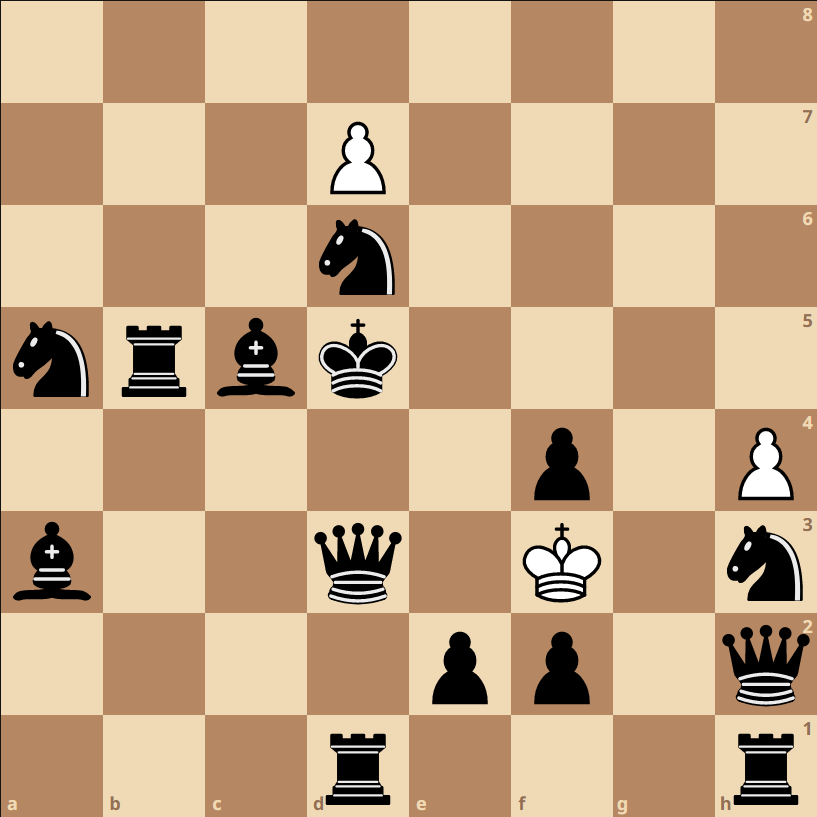

In [308]:
imgs_path = 'C:/Users/ris09/Desktop/ChessReader/geckodriver-v0.32.0-win32/self_dataset/*.png'
imgs = glob.glob(imgs_path)

im = Image.open(imgs[100])
display(im)

### Split all chessboard images into 64 squares and save the squares with corresponding labels for model training

In [78]:
for a in imgs[:10]:
    im = Image.open(a)
    im = im.resize((256,256))
    piece_order = i[-75:-4].replace('-','')

    square = []
    square_name = []
    sq=32
    for row in range(8):
        for col in range(8):
            piece = im.crop((col*sq, row*sq, (col+1)*sq , (row+1)*sq))
            piece_name = piece_order[8*(row)+col]
            square.append(piece)
            square_name.append(piece_name)
    
    for i in range(64):
        directory = 'C:/Users/ris09/Desktop/ChessReader/geckodriver-v0.32.0-win32/self_dataset/squares/'
        filename = a[-75:-4]+'_'+str(i)+'_'+square_name[i]+'.png'
        square[i].save(directory + filename)

### Loading the images as arrays and splitting them into train/test datasets

In [309]:
all_im_dir = glob.glob("C:/Users/ris09/Desktop/ChessReader/geckodriver-v0.32.0-win32/self_dataset/squares/*.png")

images = []
label = []

for i in all_im_dir:
    
    image = keras.preprocessing.image.load_img(i, target_size=(32,32))
    image_arr = keras.preprocessing.image.img_to_array(image)
    image_arr_norm = image_arr/255.0
    
    image_label = i[-5]
    
    images.append(image_arr_norm)
    label.append(image_label)
    
images = np.array(images)
label = np.array(label)

In [310]:
Xtrain, Xtest, ytrain, ytest = train_test_split(images, label, test_size=0.2)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((84275, 32, 32, 3), (21069, 32, 32, 3), (84275,), (21069,))

In [311]:
# Encoding the target variable using Label Encoding

le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.fit_transform(ytest)

# Model building

In [300]:
model_1 = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(13, activation='softmax')    
])
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [328]:
model_1.fit(Xtrain, ytrain, epochs=5, batch_size=32, validation_data=(Xtest, ytest))
loss, accuracy = model_1.evaluate(Xtest, ytest)

Epoch 1/5
2634/2634 [==============================] - 84s 30ms/step - loss: 0.0095 - accuracy: 0.9980 - val_loss: 3.9886e-06 - val_accuracy: 1.0000
Epoch 2/5
2634/2634 [==============================] - 79s 30ms/step - loss: 1.5423e-06 - accuracy: 1.0000 - val_loss: 3.4757e-07 - val_accuracy: 1.0000
Epoch 3/5
2634/2634 [==============================] - 79s 30ms/step - loss: 1.5272e-07 - accuracy: 1.0000 - val_loss: 5.3186e-08 - val_accuracy: 1.0000
Epoch 4/5
2634/2634 [==============================] - 78s 30ms/step - loss: 3.7766e-08 - accuracy: 1.0000 - val_loss: 6.0705e-08 - val_accuracy: 1.0000
Epoch 5/5
659/659 [==============================] - 9s 13ms/step - loss: 5.7520e-08 - accuracy: 1.0000


In [329]:
ev = model_1.evaluate(Xtest, ytest)
ev[0], ev[1]

659/659 [==============================] - 9s 13ms/step - loss: 5.7520e-08 - accuracy: 1.0000


(5.751964948785826e-08, 1.0)

### We see that the model has ~100% accuracy on validation set, which is suspicious
### To further validate the model, we generate some new data to which the model hasn't been trained on, or seen before

In [202]:
options = Options()
options.add_argument("start-maximized")

webdriver_service = Service(r'C:\Users\ris09\Desktop\ChessReader\chromedriver_win32_14\chromedriver.exe')
driver = webdriver.Chrome(options=options, service=webdriver_service)

In [207]:
for i in range(100):   
    fen, name = random_board()
    url = 'https://lichess.org/editor/'+fen
    driver.get(url)
    driver.save_screenshot(f"C:/Users/ris09/Desktop/ChessReader/geckodriver-v0.32.0-win32/new_data/{name}.png")

    im=Image.open(f"C:/Users/ris09/Desktop/ChessReader/geckodriver-v0.32.0-win32/new_data/{name}.png")
    im = im.crop((476, 218, 1284, 1026))
    im.save(f"C:/Users/ris09/Desktop/ChessReader/geckodriver-v0.32.0-win32/new_data/{name}.png")

In [209]:
# Splitting the images into 64 squares after resizing to 256x256, then saves the squares as separate images

imgs_path = 'C:/Users/ris09/Desktop/ChessReader/geckodriver-v0.32.0-win32/new_data/*.png'
imgs = glob.glob(imgs_path)

for a in imgs:
    im = Image.open(a)
    im = im.resize((256,256))
    piece_order = a[-75:-4].replace('-','')

    square = []
    square_name = []
    sq=32
    for row in range(8):
        for col in range(8):
            piece = im.crop((col*sq, row*sq, (col+1)*sq , (row+1)*sq))
            piece_name = piece_order[8*(row)+col]
            square.append(piece)
            square_name.append(piece_name)
    
    for i in range(64):
        directory = 'C:/Users/ris09/Desktop/ChessReader/geckodriver-v0.32.0-win32/new_data/squares/'
        filename = a[-75:-4]+'_'+str(i)+'_'+square_name[i]+'.png'
        square[i].save(directory + filename)

In [210]:
# Preparing the images for validation

Xtest_new = []
ytest_new = []

all_im_dir = glob.glob("C:/Users/ris09/Desktop/ChessReader/geckodriver-v0.32.0-win32/new_data/squares/*.png")

for i in all_im_dir:
    
    image = keras.preprocessing.image.load_img(i, target_size=(32,32))
    image_arr = keras.preprocessing.image.img_to_array(image)
    image_arr_norm = image_arr/255.0
    
    image_label = i[-5]
    
    Xtest_new.append(image_arr_norm)
    ytest_new.append(image_label)
    
Xtest_new = np.array(Xtest_new)
ytest_new = np.array(ytest_new)
ytest_new = le.fit_transform(ytest_new)

In [211]:
ev_new = model_1.evaluate(Xtest_new, ytest_new)
ev_new[0], ev_new[1]

204/204 [==============================] - 3s 11ms/step - loss: 7.0744e-08 - accuracy: 1.0000


(7.074398666873094e-08, 1.0)

### Since the evaluation on unseen data is similar to the original performance, we can conclude that the accuarcy of the model is ~100%

# Making prediction for a given image of a chessboard

In [327]:
def get_tiles(image):
    image = image.resize((256, 256))
    squares = []
    sq = 32
    
    for row in range(8):
        for column in range(8):
            square = image.crop((column*sq, row*sq, (column+1)*sq , (row+1)*sq))   
            squares.append(square)
    return squares

def tile_array(sqrs):
    sq_arr = []
    for i in sqrs:
        a = np.asarray(i)
        a = a/255.0
        sq_arr.append(a)
    return sq_arr

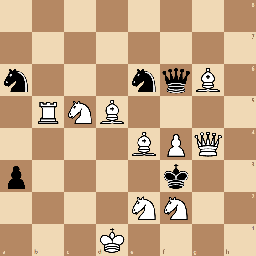

In [326]:
im_test = glob.glob(r'C:\Users\ris09\Desktop\ChessReader\geckodriver-v0.32.0-win32\test_image\*.png')
im_test = keras.preprocessing.image.load_img(im_test[0], target_size=(256,256))
display(im_test)

In [330]:
sq = get_tiles(im_test)
sq_arr = tile_array(sq)

sq_pred = []
lab_pred = []

for i in sq_arr:
    sq_prediction = model_1.predict(np.expand_dims(i, axis=0))
    sq_pred.append(np.argmax(sq_prediction))

    lab_predicted = le.inverse_transform([np.argmax(sq_prediction)])
    lab_pred.append(lab_predicted[0])

lab_pred

1/1 [==============================] - 0s 60ms/step


['1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 'n',
 '1',
 '1',
 '1',
 'n',
 'q',
 'B',
 '1',
 '1',
 'R',
 'N',
 'B',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 'B',
 'P',
 'Q',
 '1',
 'p',
 '1',
 '1',
 '1',
 '1',
 'k',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 'N',
 'N',
 '1',
 '1',
 '1',
 '1',
 '1',
 'K',
 '1',
 '1',
 '1',
 '1']

In [332]:
pred_board = [lab_pred[i:i+8] for i in range(0,64,8)]
pred_board = [[' ' if i=='1' else i for i in row] for row in pred_board]
predicted_fen = fen_from_board(pred_board)
print(predicted_fen) # The final FEN position of the chessboard in the image

link = 'https://lichess.org/analysis/'+predicted_fen
lichess_link_white = link.replace(' ','_')
lichess_link_black = lichess_link_white.replace('w','b')

# Providing the link to Lichess website to continue the game from the position in the image
print(f'White to play {lichess_link_white} \nBlack to play {lichess_link_black}')

8/8/n3nqB1/1RNB4/4BPQ1/p4k2/4NN2/3K4 w - - 0 1
White to play https://lichess.org/analysis/8/8/n3nqB1/1RNB4/4BPQ1/p4k2/4NN2/3K4_w_-_-_0_1 
Black to play https://lichess.org/analysis/8/8/n3nqB1/1RNB4/4BPQ1/p4k2/4NN2/3K4_b_-_-_0_1
